In [40]:
#Import libraries

In [42]:
import os
import sys
import pandas as pd
import joblib
import shap
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,
    roc_curve, auc
)
from sklearn.exceptions import ConvergenceWarning
import warnings

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [44]:
# Preprocessing Functions

In [46]:
def load_and_resample_data(filepath):
    data = pd.read_csv(filepath)
    X = data.drop(columns=['Class'])
    y = data['Class']

    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)

    return X_res, y_res

def split_and_scale(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled

In [48]:
#Model Functions

In [50]:
def get_models():
    models = {
        "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": xgb.XGBClassifier(eval_metric='logloss', random_state=42),
        "LightGBM": lgb.LGBMClassifier(random_state=42),
        "CatBoost": CatBoostClassifier(verbose=0, random_seed=42)
    }
    return models

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, probs)
    cm = confusion_matrix(y_test, preds)

    print(f"--- {name} ---")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

    return {'model': name, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc}

def cross_validate_model(model, X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
    return scores.mean(), scores.std()

In [52]:
# Visualization Functions

In [54]:
def plot_class_distribution(y_before, y_after):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.countplot(x=y_before, ax=axes[0])
    axes[0].set_title('Class Distribution Before SMOTE')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')

    sns.countplot(x=y_after, ax=axes[1])
    axes[1].set_title('Class Distribution After SMOTE')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(data):
    plt.figure(figsize=(14, 10))
    sns.heatmap(data.corr(), cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

def plot_confusion_matrix_heatmap(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_roc_curves(models, X_test_scaled, X_test, y_test):
    plt.figure(figsize=(10, 7))

    for name, model in models.items():
        if name == "Logistic Regression":
            probs = model.predict_proba(X_test_scaled)[:, 1]
        else:
            probs = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

def shap_summary_plot(model, X_test):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test[:100])
    shap.summary_plot(shap_values, X_test[:100]) 

In [56]:
# Main Pipeline Execution

In [58]:
original_data = pd.read_csv('data/creditcard.csv')
X_resampled, y_resampled = load_and_resample_data('data/creditcard.csv')


In [59]:
# Visualizations

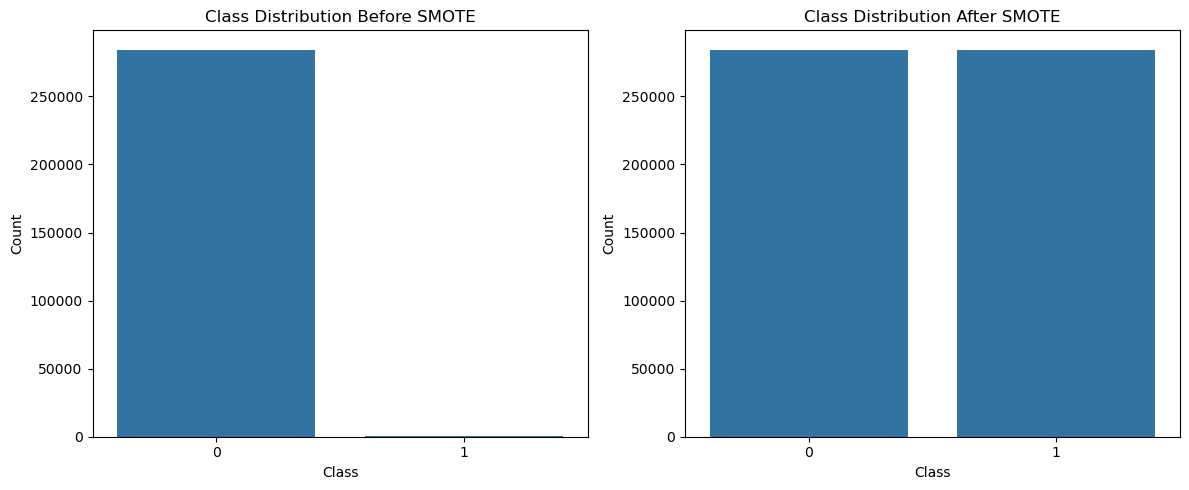

In [60]:
plot_class_distribution(original_data['Class'], y_resampled)

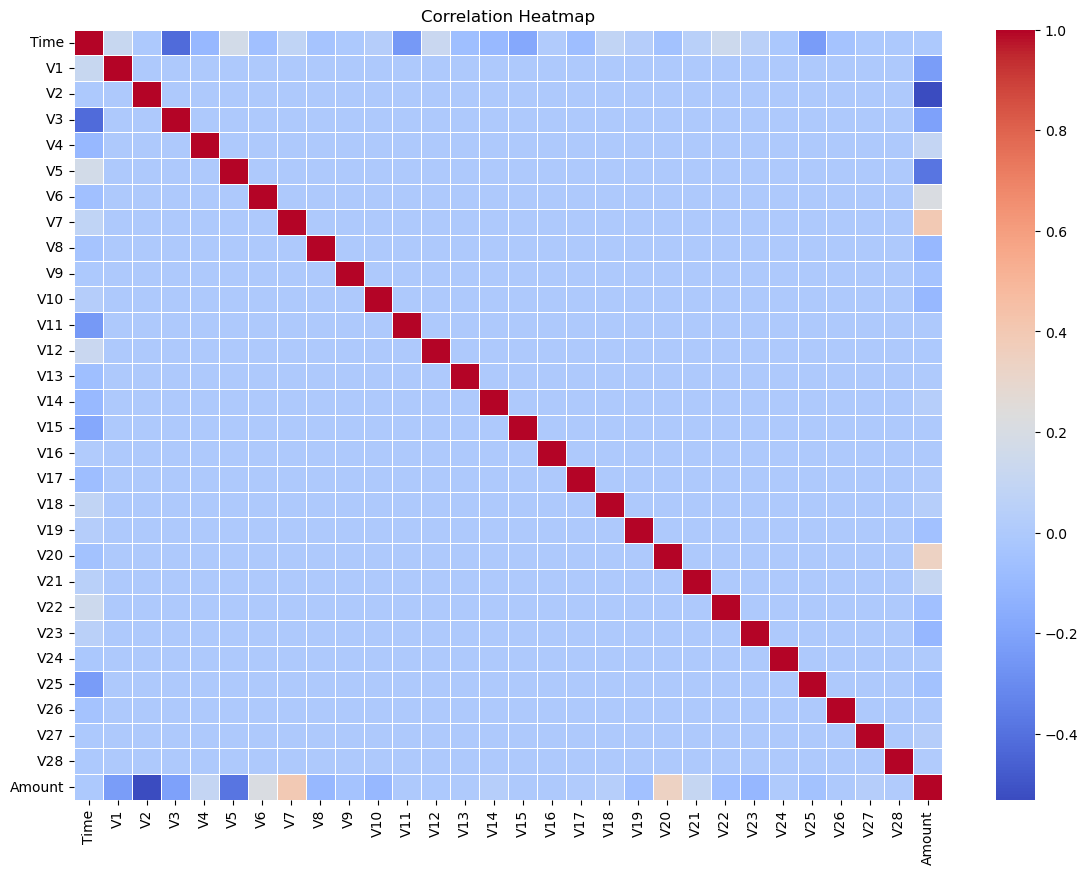

In [64]:
plot_correlation_heatmap(original_data.drop(columns='Class'))

In [66]:
# Splitting and scaling

In [68]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = split_and_scale(X_resampled, y_resampled)

In [70]:
# Model evaluation

In [72]:
models = get_models()
results = []

for name, model in models.items():
    if name == "Logistic Regression":
        res = evaluate_model(name, model, X_train_scaled, X_test_scaled, y_train, y_test)
    else:
        res = evaluate_model(name, model, X_train, X_test, y_train, y_test)
    results.append(res)

--- Logistic Regression ---
Precision: 0.9907
Recall:    0.9702
F1-score:  0.9803
ROC-AUC:   0.9974
Confusion Matrix:
[[56343   520]
 [ 1692 55171]]

--- Random Forest ---
Precision: 0.9997
Recall:    1.0000
F1-score:  0.9998
ROC-AUC:   1.0000
Confusion Matrix:
[[56846    17]
 [    1 56862]]

--- XGBoost ---
Precision: 0.9996
Recall:    1.0000
F1-score:  0.9998
ROC-AUC:   1.0000
Confusion Matrix:
[[56841    22]
 [    0 56863]]

[LightGBM] [Info] Number of positive: 227452, number of negative: 227452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454904, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
--- LightGBM ---
Precision: 0.9989
Recall:    0.9999
F1-score:  0.9994
ROC-AUC:   0.9999
Confusion Matrix:
[[56803    60]
 [  

In [74]:
# Cross-validation for logistic regression

In [76]:
mean_auc, std_auc = cross_validate_model(models["Logistic Regression"], X_resampled, y_resampled)
print(f"Logistic Regression CV ROC-AUC: {mean_auc:.4f} ± {std_auc:.4f}")

Logistic Regression CV ROC-AUC: 0.9973 ± 0.0001


In [90]:
# SHAP and Confusion Matrix for XGBoost

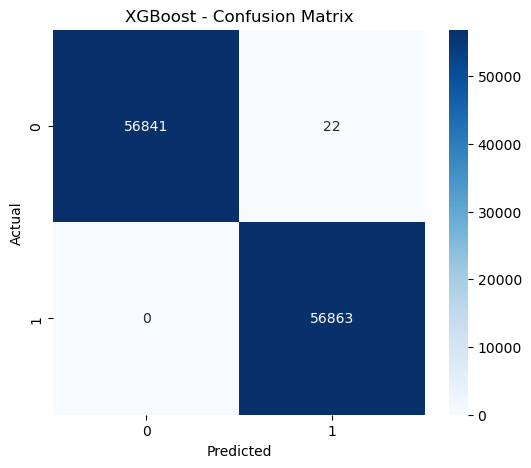

In [92]:
xgb_model = models['XGBoost']
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
plot_confusion_matrix_heatmap(y_test, xgb_preds, title="XGBoost - Confusion Matrix")

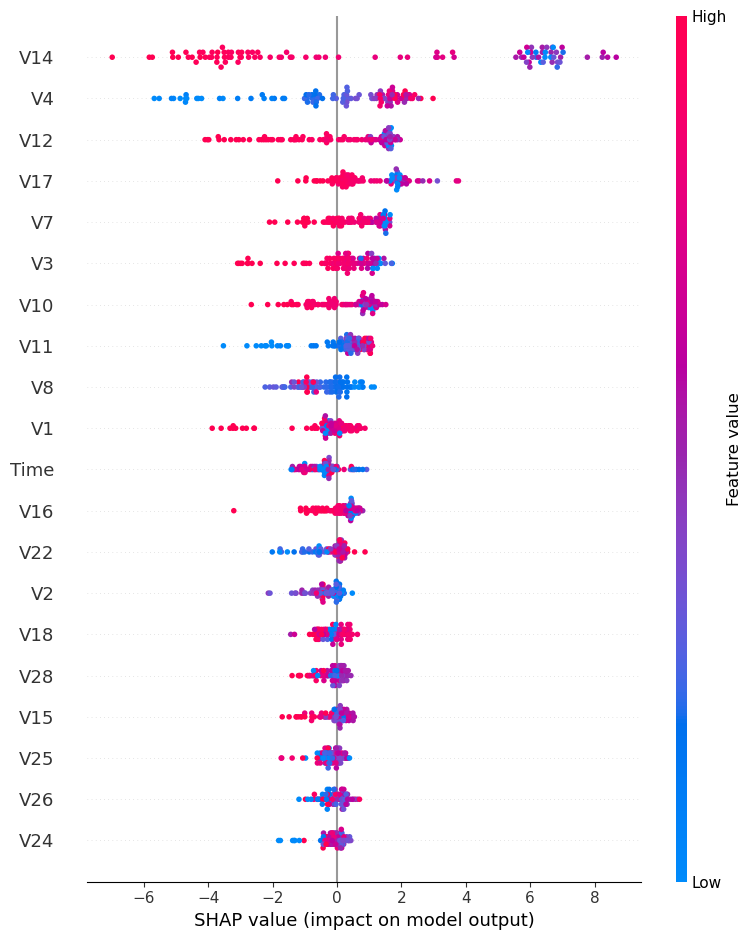

In [94]:
shap_summary_plot(xgb_model, X_test)

In [95]:
# ROC Curves

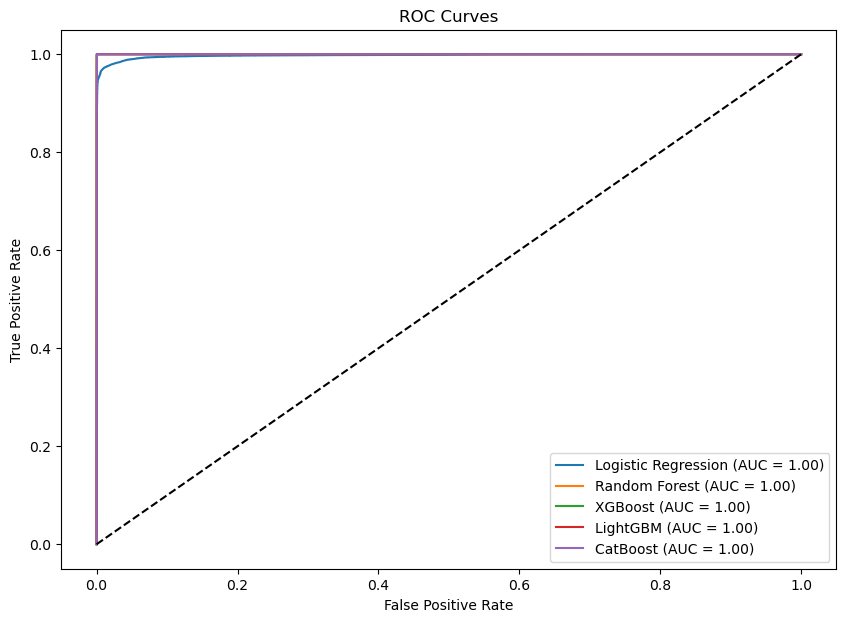

In [98]:
plot_roc_curves(models, X_test_scaled, X_test, y_test)

In [99]:
# Save the best model

In [102]:
joblib.dump(xgb_model, 'models/xgb_creditcard_model.joblib')
print("Model saved successfully.")

Model saved successfully.
